# 1. Introduction

A family living in Los Angeles California is looking to move to nearby "Desert Cities" located in the Riverside County. Located in the San Bernedino valley, these cities are well connected and the family can reside in any one while working in another one. These cities include:
- Cathedral City
- Coachella
- Desert Hot Springs
- Indian Wells
- Indio
- La Quinta
- Palm Desert
- Palm Springs
- Rancho Mirage

The family is free to chose any of these cities to live in, they will be looking at 3 factors
1. Crime Rate in given city
2. Average Home Price
3. Type of Housing available


# 2. Data
We will be using the following data sets
1. Homeland Infradstructure Foundation-Level Data (HIFLD) Provides a wide array of datasets, we will be using the geographical information about cities

https://hifld-geoplatform.opendata.arcgis.com

2. FBI provides crime reporting statistics on cities 

https://crime-data-explorer.fr.cloud.gov/pages/docApi

3. For Real-Estate information, may APIs are closed or required payment. Since we only need a sample size we will be using Web Scraping with BeautifulSoup to scrape the Zillow website for relevant information


# 3. Methodology
Let's explore the geographical data, then based on that lets find out the criminal and property cities in the surrounding area. Finally, using k-mean algorithm we will cluster the cities. The result will give us a ideas on possible favorable housing cities. 


## Import Libraries

In [69]:
import sys
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/Python.framework/Versions/3.7/lib/python3.7/site-packages')
sys.path.append('/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages')
 
sys.path

import pandas as pd
import urllib
import requests
import json
import simplejson as json
import geocoder
import folium # map rendering library
import csv
import time
import numpy as np
import branca.colormap as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd

from requests.auth import HTTPBasicAuth
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup
from branca.utilities import split_six
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist



## 3.1 Riverside County Geographical Information

In [3]:
url_cities = "https://geo.dot.gov/server/rest/services/Hosted/Populated_Places_DS/FeatureServer/0/query?where=countyfips%20%3D%20'065'%20AND%20state%20%3D%20'CA'%20AND%20longitude%20%3E%3D%20-116.687%20AND%20longitude%20%3C%3D%20-115.909&outFields=ansicode,feature,feature2,name,pop_2010,county,countyfips,state,state_fips,latitude,longitude,poppllat,poppllong,elev_in_m,elev_in_ft&outSR=4326&f=json"
data_cities = json.loads(requests.get(url_cities).content.decode('utf-8'))
cities = pd.json_normalize(data_cities['features'])
cities.head()

attributes.ansicode attributes.feature attributes.feature2 attributes.name  \
0             2407831             Census                -999   Bermuda Dunes   
1             2408811             Census                -999           Mecca   
2             2409313             Census                -999  Thousand Palms   
3             2409412              Civil                -999  Cathedral City   
4             2409493              Civil                -999       Coachella   

   attributes.pop_2010 attributes.county attributes.countyfips  \
0               7282.0         Riverside                   065   
1               8577.0         Riverside                   065   
2               7715.0         Riverside                   065   
3              51200.0         Riverside                   065   
4              40704.0         Riverside                   065   

  attributes.state attributes.state_fips  attributes.latitude  \
0               CA                    06            33.742799   
1               CA                    06            33.571692   
2               CA                    06            33.820018   
3               CA                    06            33.779743   
4               CA                    06            33.680300   

   attributes.longitude  attributes.poppllat  attributes.poppllong  \
0           -116.289175            33.742799           -116.289175   
1           -116.077224            33.571692           -116.077224   
2           -116.390289            33.820018           -116.390289   
3           -116.465291            33.779743           -116.465291   
4           -116.173894            33.680300           -116.173894   

   attributes.elev_in_m  attributes.elev_in_ft  geometry.x  geometry.y  
0                  29.0                   95.0 -116.289187   33.742804  
1                 -57.0                 -187.0 -116.077236   33.571697  
2                  75.0                  246.0 -116.390301   33.820023  
3                 100.0                  328.0 -116.465303   33.779748  
4                 -21.0                  -69.0 -116.173906   33.680305

In [4]:
# We're only going to clean up the data, keeping only the relevant information.
new_cols = []
for col in cities.columns:
    new_cols.append(col.split('.')[1])
cities.columns = new_cols
df_cities = cities[['name','state','pop_2010', 'latitude','longitude','x','y']]

#drop Anza and desert springs county as they are irrelevant
df_cities = df_cities[df_cities['name'] != 'Anza']
df_cities = df_cities[df_cities['name'] != 'Palm Desert Country']


In [63]:
# We're going need the Palm Desert coordinates which will serve as the center for our maps.
city = 'Palm Desert, CA'

geolocator = Nominatim(user_agent='riverside_explorer')
location = geolocator.geocode(city)
lat = location.latitude
lng = location.longitude

print('Geo Location is : {} Latitiude, {} Longitude'. format(lat, lng))

Geo Location is : 33.74079965 Latitiude, -116.36936983394352 Longitude


In [6]:
# create riverside map, and then we add all the cities to the map.
riverside_map = folium.Map(width=500, height=500, location=[lat,lng], zoom_start=10,)
for lat, lng, city, pop in zip(df_cities['latitude'], df_cities['longitude'], df_cities['name'], df_cities['pop_2010']):
    label= '{}, {}'.format(city, pop)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=5,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)
riverside_map

These are all possible cities we will be looking at, we still need to filter it down after we get real-estate data.

# 3.2 Riverside Real Estate Data (Web Scrapping Zillow.com)
We will be webscraping real-estate data to get samples for housing pricing information for the relevant cities. After getting the data we will need to clean and filter out the data to have all the relevant information

In [7]:
# We're going to scrape zillow to find relevant real-estate information regarding the areas we are interested in.
class ZillowScrapper():

    def __init__(self, city='Palm Springs', state='CA'):
        self.city = city
        self.state = state

    results  = []
    headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }

    def fetch(self, url, params):
        response = requests.get(url, headers=self.headers, params=params)
        print(response.status_code)
        return response

    def parse(self, response):
        content = BeautifulSoup(response, 'lxml')
        deck = content.find('ul', {'class':'photo-cards photo-cards_wow photo-cards_short photo-cards_extra-attribution'})
        for card in deck.contents:
            script = card.find('script', {'type':'application/ld+json'}) 
            if script:
                script_json = json.loads(script.contents[0])
                try:
                    self.results.append({
                        'latitude': script_json['geo']['latitude'],
                        'longitude': script_json['geo']['longitude'],
                        'floorSize': script_json['floorSize']['value'],
                        'url': script_json['url'],
                        'price': card.find('div', {'class':'list-card-price'}).text,
                        'details': card.find('ul', {'class':'list-card-details'}).text,
                        'address':card.find('address',{'class':'list-card-addr'}).text
                    })
                except:
                    pass
                    # print(script_json)
        # print(self.results)


    def run(self):
        # city = self.city
        # state = self.city

        url = 'https://www.zillow.com/homes/for_sale/'
        # .format(city, state) 

        for page in range(1,20):
            params = {
            'searchQueryState': '{"pagination":{"currentPage":%s},"usersSearchTerm":"Riverside, CA","mapBounds":{"west":-116.73594918758027,"east":-115.8364435723459,"south":33.43613945636894,"north":34.202829290316075},"customRegionId":"4925860f54X1-CR1uopkv7mw2rni_11t4o6","isMapVisible":false,"filterState":{"ah":{"value":true},"sort":{"value":"globalrelevanceex"}},"isListVisible":true}' %page
            }
            if params:
                res = self.fetch(url, params)
                self.parse(res.text)
                time.sleep(2)

if __name__ == '__main__':
    scraper = ZillowScrapper()
    scraper.run()

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [75]:
#  Lets vizualize the results in a data frame
homes = ZillowScrapper.results
home_prices = pd.json_normalize(homes)
home_prices.head()

latitude   longitude floorSize  \
0  33.738061 -116.364176     1,233   
1  33.962587 -116.571054     1,618   
2  33.824434 -116.396561     1,875   
3  33.756014 -116.389203     1,850   
4  33.754975 -116.388469     1,850   

                                                 url     price  \
0  https://www.zillow.com/homedetails/74546-Gary-...  $437,900   
1  https://www.zillow.com/homedetails/11836-Skyla...  $389,000   
2  https://www.zillow.com/homedetails/30914-Rober...  $429,900   
3  https://www.zillow.com/homedetails/40328-Sagew...  $549,900   
4  https://www.zillow.com/homedetails/40243-Sagew...  $524,900   

                               details  \
0  3 bds2 ba1,233 sqft- House for sale   
1  3 bds3 ba1,618 sqft- House for sale   
2  4 bds2 ba1,875 sqft- House for sale   
3  3 bds2 ba1,850 sqft- House for sale   
4  3 bds2 ba1,850 sqft- House for sale   

                                          address  
0           74546 Gary Ave, Palm Desert, CA 92260  
1  11836 Skylark St, Desert Hot Springs, CA 92240  
2       30914 Robert Rd, Thousand Palms, CA 92276  
3        40328 Sagewood Dr, Palm Desert, CA 92260  
4        40243 Sagewood Dr, Palm Desert, CA 92260

The above result contains a lot of inromation we wont need, furthermore we need to filter the details so we get better information on the type of property. The city is also needs to be extracted from the address.

In [78]:
# Lets get the bedrooms, bathrooms and house details from the dataframe
import re
separators = "bd", "ba", "sqft-"
details = []
def custom_split(sepr_list, str_to_split):
    # create regular expression dynamically
    regular_exp = '|'.join(map(re.escape, sepr_list))
    return re.split(regular_exp, str_to_split)

for x in home_prices['details']:
    details.append(custom_split(separators, x))

#append details as a new column
home_prices['list_details'] = details
#split in to columns
home_prices[['bedrooms','bathrooms','size','type']] = pd.DataFrame(home_prices['list_details'].tolist(), index= home_prices.index)
#remove redundant columns
home_prices.drop(['details', 'list_details','size'], axis=1, inplace=True)

Extract the city name fromt he address

In [79]:
sep = ',',','
lists=[]
for x in home_prices.address:
    lists.append(custom_split(sep,x))
home_prices['ad_details'] = lists
home_prices[['del1','address','del2']] = pd.DataFrame(home_prices['ad_details'].tolist(), index=home_prices.index)
home_prices.drop(['del1','url','del2','ad_details'], axis=1, inplace=True)


Many of the columns are currently as Object, we would need to convert it to numeric format for further analysis

In [80]:
# convert columns to numeric values
home_prices['bathrooms']= home_prices['bathrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms']= home_prices['bedrooms'].str.extract('(\d+)', expand=False)
home_prices['bedrooms'] = pd.to_numeric(home_prices['bedrooms']) 
home_prices['bathrooms'] = pd.to_numeric(home_prices['bathrooms']) 
home_prices['floorSize'] = home_prices['floorSize'].str.replace(',', '')
home_prices['floorSize'] = pd.to_numeric(home_prices['floorSize'])
home_prices['price'] = home_prices['price'].str.replace(r"[^0-9]", '')
home_prices['price'] = pd.to_numeric(home_prices['price'])

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


We will remove properties with no bedrooms or bathrooms which are basically lots. The family will not be considering lots but only already built homes.

In [81]:
# Clean up rows (no bathrooms, no bedrooms, lots)
home_prices.drop(home_prices[pd.isnull(home_prices.bathrooms)].index, inplace=True ) 
home_prices.drop(home_prices[pd.isnull(home_prices.type)].index, inplace=True ) 

Finally lets plot all the homes we got on a map

In [13]:
#plot homes for sale on map
for lat, lng, price in zip(home_prices['latitude'], home_prices['longitude'], home_prices['price']):
    label= '{}'.format(price)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(riverside_map)

riverside_map

From the above data, we can see some cities have very little or no housing information, we will not consider those places due to lack of choices

## 3.2 Exploratory Data Analysis: Crime Data Analysis
We will be downloading the crime data from the FBI database via API

In [14]:
# Download police station info for the relevant area.
url_crime_station = 'https://api.usa.gov/crime/fbi/sapi/api/agencies/byStateAbbr/CA?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
data_crime_station = json.loads(requests.get(url_crime_station).content.decode('utf-8'))

We need to filter out the cities, and keep only relevant cities

In [15]:
# filter the police stations to only the ones we are interested in. 
ca_police = pd.json_normalize(data_crime_station['results'])
desert_police = ca_police[ca_police['county_name'] == 'RIVERSIDE']
desert_police = desert_police[desert_police['agency_type_name'] == 'City']

data_pol = []
for n in df_cities.name:
    n = n.lower()
    station = desert_police[desert_police['agency_name'].str.lower().str.contains(n)]
    data_pol.append(station)
    
df_police = pd.concat(data_pol)
df_police.reset_index(drop=True)
df_police.head()

ori                           agency_name agency_type_name  \
417  CA0332500      Cathedral City Police Department             City   
402  CA0330500           Coachella Police Department             City   
412  CA0331600        Indian Wells Police Department             City   
405  CA0330900               Indio Police Department             City   
403  CA0330600  Desert Hot Springs Police Department             City   

     state_name state_abbr division_name region_name region_desc county_name  \
417  California         CA       Pacific        West   Region IV   RIVERSIDE   
402  California         CA       Pacific        West   Region IV   RIVERSIDE   
412  California         CA       Pacific        West   Region IV   RIVERSIDE   
405  California         CA       Pacific        West   Region IV   RIVERSIDE   
403  California         CA       Pacific        West   Region IV   RIVERSIDE   

     nibrs   latitude   longitude nibrs_start_date  
417  False  33.729828 -116.002239             None  
402  False  33.978046 -117.374020             None  
412  False  33.978046 -117.374020             None  
405  False  33.708570 -116.216410             None  
403  False  33.729828 -116.002239             None

Now we need to get the crime data for each police station, we wil be using the STATION CODE (ORI) and then search the FBI database for the relevant crime cases.

In [16]:
# Get station codes
station_codes = df_police['ori']

# Get crime records for each station code, we will use the police station inforamtion to make another API call.

def getRecord(station_codes):
    allRecord = []
    for station_code in station_codes:
        url_crime_record = 'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/' + station_code + '/offenses/2015/2019?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv'
        data_crime_record = json.loads(requests.get(url_crime_record).content.decode('utf-8'))
        df_crime_record = pd.json_normalize(data_crime_record['results'])
        
        agg_crime_record = df_crime_record.groupby('offense').agg({'actual':'sum'}).T
        agg_crime_record['case_number'] = agg_crime_record.iloc[:, -12:-1].sum(axis=1)
        agg_crime_record['ori'] = station_code
        allRecord.append(agg_crime_record)
    
    allRecord = pd.concat(allRecord, axis = 0, ignore_index = True, sort = False)
    cols = allRecord.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    allRecord = allRecord[cols]
    
    return allRecord
getRecord(station_codes)

offense        ori  aggravated-assault  arson  burglary  homicide  \
0        CA0332500                 381     25      1148        19   
1        CA0330500                 400     23       872         6   
2        CA0331600                  22      0       194         0   
3        CA0330900                1920     30      2012        16   
4        CA0330600                 927     28      1857        27   
5        CA0331800                 345     11      1846         4   
6        CA0331100                 808     26      3104        20   
7        CA0331700                 122      0       725         0   
8        CA033310X                 183      7       848         8   

offense  human-trafficing  larceny  motor-vehicle-theft  property-crime  rape  \
0                       0     1784                 1405            4337    86   
1                       0     3770                 1076            5718    29   
2                       0      455                   40             689     2   
3                       0     6415                 2038           10465   185   
4                       0     1116                 1165            4138    83   
5                       0     7822                  688           10356    21   
6                       0     7227                 1459           11790   165   
7                       0     2376                  277            3378     5   
8                       0     4492                  348            5688    25   

offense  rape-legacy  robbery  violent-crime  case_number  
0                  0      236            722         9421  
1                  0      237            672        12131  
2                  0        4             28         1406  
3                  0      565           2686        23646  
4                  0      276           1313         9617  
5                  0      142            512        21235  
6                  0      392           1385        24991  
7                  0       34            161         6917  
8                  0      127            343        11726

Finally we need to merged crime with the police station in each city, then we need to get an yearly average as the above data is for 5 years.

In [17]:
allRecords = getRecord(station_codes)
# Merge total crime per police department with police stations. 
#Remove uncessary columns

df_crime_data = pd.merge(df_police, allRecords, on='ori')
df_crime_stats = df_crime_data.drop(['longitude', 'latitude','ori','agency_type_name','state_name','state_abbr','division_name','region_name','region_desc','county_name','nibrs','nibrs_start_date'], axis=1)
df_crime_stats

# divide by 5 to average out the 5 years, as we have 5 years of data.
df_crime_stats.iloc[:,1:14] = df_crime_stats.iloc[:,1:14].divide(5)

#Retreive city name from police station
df_crime_stats[['name','pol']] = pd.DataFrame(df_crime_stats['agency_name'].str.split('Police').to_list(), index= df_crime_stats.index) 
df_crime_stats.drop(['pol'], axis=1, inplace=True)
# re-arrange columns
cols = df_crime_stats.columns.to_list()
cols = cols[-1:] + cols[:-1]
df_crime_stats = df_crime_stats[cols]
# Clean before merge
df_cit = df_cities.sort_values('name')
df_cri = df_crime_stats.sort_values('name')
df_cit['name'] = df_cit['name'].str.strip()
df_cri['name'] = df_cri['name'].str.strip()
# merge crime and cities info
df_cri.reset_index( inplace=True, drop=True)
df_crime = pd.merge(df_cit, df_cri, on='name', how='inner')
df_crime['crime_rate'] = df_crime['case_number']/df_crime['pop_2010']
df_crime.sort_values('crime_rate', ascending=False)

name state  pop_2010   latitude   longitude           x  \
7        Palm Springs    CA   44552.0  33.830296 -116.545292 -116.545304   
6         Palm Desert    CA   48445.0  33.722245 -116.374456 -116.374467   
8       Rancho Mirage    CA   17218.0  33.739744 -116.412790 -116.412802   
2  Desert Hot Springs    CA   25938.0  33.961124 -116.501678 -116.501690   
5           La Quinta    CA   37467.0  33.663357 -116.310010 -116.310021   
4               Indio    CA   76036.0  33.720577 -116.215562 -116.215574   
1           Coachella    CA   40704.0  33.680300 -116.173894 -116.173906   
3        Indian Wells    CA    4958.0  33.718633 -116.308343 -116.308354   
0      Cathedral City    CA   51200.0  33.779743 -116.465291 -116.465303   

           y                           agency_name  aggravated-assault  arson  \
7  33.830301        Palm Springs Police Department               161.6    5.2   
6  33.722249         Palm Desert Police Department                69.0    2.2   
8  33.739749       Rancho Mirage Police Department                24.4    0.0   
2  33.961129  Desert Hot Springs Police Department               185.4    5.6   
5  33.663362           La Quinta Police Department                36.6    1.4   
4  33.720582               Indio Police Department               384.0    6.0   
1  33.680305           Coachella Police Department                80.0    4.6   
3  33.718638        Indian Wells Police Department                 4.4    0.0   
0  33.779748      Cathedral City Police Department                76.2    5.0   

   ...  human-trafficing  larceny  motor-vehicle-theft  property-crime  rape  \
7  ...               0.0   1445.4                291.8          2358.0  33.0   
6  ...               0.0   1564.4                137.6          2071.2   4.2   
8  ...               0.0    475.2                 55.4           675.6   1.0   
2  ...               0.0    223.2                233.0           827.6  16.6   
5  ...               0.0    898.4                 69.6          1137.6   5.0   
4  ...               0.0   1283.0                407.6          2093.0  37.0   
1  ...               0.0    754.0                215.2          1143.6   5.8   
3  ...               0.0     91.0                  8.0           137.8   0.4   
0  ...               0.0    356.8                281.0           867.4  17.2   

   rape-legacy  robbery  violent-crime  case_number  crime_rate  
7          0.0     78.4          277.0       4998.2    0.112188  
6          0.0     28.4          102.4       4247.0    0.087666  
8          0.0      6.8           32.2       1383.4    0.080346  
2          0.0     55.2          262.6       1923.4    0.074154  
5          0.0     25.4           68.6       2345.2    0.062594  
4          0.0    113.0          537.2       4729.2    0.062197  
1          0.0     47.4          134.4       2426.2    0.059606  
3          0.0      0.8            5.6        281.2    0.056716  
0          0.0     47.2          144.4       1884.2    0.036801  

[9 rows x 22 columns]

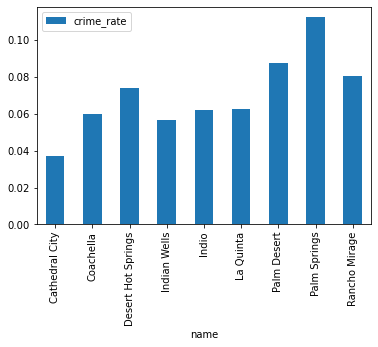

In [23]:
# Plot most crime-ridden city
ax = df_crime.plot.bar(x='name', y='crime_rate')

We can see that Palm Springs and Plam Desert have the highest crime rate, with Cathedral city with the far lowest crime rate.

## Plotting the Cities and Crime Rates on Map
We start with defining the geographical boundries of the cities. We downloaded a .shx file containing the geographical info.

In [44]:
fp = '500Cities/tl_2020_06_place.shx'
map_df = gpd.read_file(fp)
cities = df_crime.name.unique()
# map_of_cities = map_df[map_df['NAME'].isin(cities)].plot(label='NAME', column='NAME',figsize=(12,14), cmap='PiYG', linewidth=1, edgecolor='0.9', legend=True)

We need to merge the cities geographical data with the crime data for each city

In [45]:
map_cit_df = map_df[['NAME','geometry']]
df_crime_small = df_crime[['name','crime_rate','case_number']]
df_crime_small.rename(columns={'name':'NAME'}, inplace=True)

df_crime_cit = map_cit_df.merge(df_crime_small, on='NAME')
df_crime_cit.head()

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


NAME                                           geometry  \
0           Indio  POLYGON ((-116.30127 33.81647, -116.29218 33.8...   
1  Cathedral City  POLYGON ((-116.50327 33.88036, -116.50320 33.8...   
2     Palm Desert  POLYGON ((-116.42551 33.71414, -116.42198 33.7...   
3       Coachella  MULTIPOLYGON (((-116.20339 33.64793, -116.2033...   
4    Indian Wells  POLYGON ((-116.37355 33.68380, -116.37311 33.6...   

   crime_rate  case_number  
0    0.062197       4729.2  
1    0.036801       1884.2  
2    0.087666       4247.0  
3    0.059606       2426.2  
4    0.056716        281.2

In [46]:
# find the center points from the coordinates so we can plot it on map
x_map=df_crime_cit.centroid.x.mean()
y_map=df_crime_cit.centroid.y.mean()

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


Create a map centered on the in the middle

In [93]:
crimemap = folium.Map(location=[y_map,x_map], zoom_start=11, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(crimemap)


Create a Choropleth map, with crime rate on it

In [94]:
crimemap.choropleth(
    geo_data=df_crime_cit,
    name='Choropleth',
    data=df_crime_cit,
    columns=['NAME','crime_rate'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Crime Rate (per 100)',
 smooth_factor=0
)


/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Add additional information about crime rate on mouse-over

In [96]:
style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':'YlGnBu', 
                            'fillOpacity':0.15}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    df_crime_cit,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','crime_rate'],
        aliases=['City: ','Crime Rate in %: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        sticky=True
    )
)
crimemap.add_child(NIL)
crimemap.keep_in_front(NIL)
folium.LayerControl().add_to(crimemap)


### Backup the data frames to CSV 

In [18]:
#Export to CSV
df_crime.to_csv('df_crime.csv')
home_prices.to_csv('home_prices.csv')


In [3]:
df_crime = pd.read_csv('df_crime.csv')
home_prices = pd.read_csv('home_prices.csv')
home_prices = home_prices.iloc[:,1:9]

## 3.3 Exploratory Data Analysis: Home Prices Analysis
We start with a descriptive statistics about our dataset


In [4]:
home_prices.describe().apply(lambda s: s.apply('{0:.2f}'.format))

latitude longitude floorSize       price bedrooms bathrooms
count   163.00    163.00    161.00      163.00   163.00    163.00
mean     33.78   -116.40   2102.60   723299.47     2.98      2.69
std       0.08      0.10   1305.88   940855.61     1.03      1.09
min      33.64   -116.57    816.00      440.00     1.00      1.00
25%      33.73   -116.48   1346.00   322000.00     2.00      2.00
50%      33.77   -116.40   1680.00   469990.00     3.00      2.00
75%      33.82   -116.33   2411.00   695000.00     3.00      3.00
max      33.99   -116.17   8281.00  8495000.00     8.00      7.00

We can see the standar deviation in floor size varies a lot, meaning that there are a lot of different types of homes. Lets visualize these elements in scatter plot.

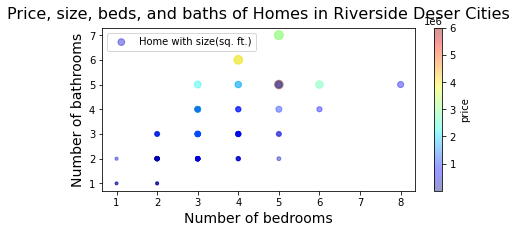

In [5]:
fig, ax = plt.subplots(figsize = (7,3))

home_prices.plot(ax = ax, kind = 'scatter', x = 'bedrooms', y = 'bathrooms', 
 s = home_prices['floorSize']/100, label = 'Home with size(sq. ft.)',
 c = 'price', cmap = plt.get_cmap('jet'), vmax = 6000000,
 colorbar = True, alpha = 0.4).set_title('Price, size, beds, and baths of Homes in Riverside Deser Cities', 
 fontsize = 16, ha = 'center', va = 'bottom')

ax.set_xlabel('Number of bedrooms', fontsize = 14)
ax.set_ylabel('Number of bathrooms', fontsize = 14)
plt.show()

We can see some correlation between price and number of bathrooms and bedrooms. But that is not always the case.

In [6]:
#Strip the empty spaces and remove empty cities from the home prices data frame
home_prices['address'] = home_prices['address'].apply(lambda x: x.strip())
filt_cit = home_prices['address'].isin(df_crime['name'].unique()) 
home_prices = home_prices[filt_cit]



### Average Price per City
Let's figure out the average price per property in each city

In [7]:
#group and average city prices
avg_price = pd.DataFrame(home_prices.groupby('address')['price'].mean())
avg_price['price'] = avg_price['price'].astype('int64')
avg_price.reset_index(inplace=True)
# avg_price['price'] = avg_price['price'].map('{:,d}'.format)
avg_price = avg_price.rename(columns={'address':'NAME'})
avg_price

NAME    price
0      Cathedral City   383047
1           Coachella   310000
2  Desert Hot Springs   285614
3        Indian Wells  1966000
4               Indio   608746
5           La Quinta  1798618
6         Palm Desert   493133
7        Palm Springs   910654
8       Rancho Mirage   963500

The prices vary quite a bit! Indian Wells prices are almost 2 million dollars, while Desert Hot Springs averages at less that 300,000 dollars. This can be due to property prices.

In [8]:
pd.crosstab(home_prices.type, home_prices.address, values=home_prices.price, aggfunc='mean').round(0)

address                      Cathedral City  Coachella  Desert Hot Springs  \
type                                                                         
 Auction                                NaN        NaN                 NaN   
 Coming soon                            NaN        NaN                 NaN   
 Condo for sale                    316280.0        NaN                 NaN   
 Foreclosure                            NaN        NaN                 NaN   
 Home for sale                      90283.0        NaN             97600.0   
 House for sale                    586091.0   310000.0            374809.0   
 Multi-family home for sale        240000.0        NaN                 NaN   
 New construction                       NaN        NaN            277400.0   
 Townhouse for sale                     NaN        NaN                 NaN   

address                      Indian Wells     Indio  La Quinta  Palm Desert  \
type                                                                          
 Auction                              NaN       NaN        NaN        440.0   
 Coming soon                    1000000.0       NaN        NaN     385000.0   
 Condo for sale                       NaN       NaN   557000.0     419237.0   
 Foreclosure                          NaN       NaN        NaN     290000.0   
 Home for sale                        NaN   55000.0        NaN     226125.0   
 House for sale                 2449000.0  654892.0  2067838.0     618719.0   
 Multi-family home for sale           NaN       NaN        NaN          NaN   
 New construction                     NaN       NaN   781990.0          NaN   
 Townhouse for sale                   NaN       NaN        NaN     319000.0   

address                      Palm Springs  Rancho Mirage  
type                                                      
 Auction                              NaN            NaN  
 Coming soon                    3499000.0            NaN  
 Condo for sale                  367000.0       506571.0  
 Foreclosure                          NaN            NaN  
 Home for sale                   183233.0       173000.0  
 House for sale                 1228250.0      1462125.0  
 Multi-family home for sale           NaN            NaN  
 New construction                     NaN            NaN  
 Townhouse for sale              499000.0            NaN

From the cross tab we can see that in Desert Hot Springs the houses are indeed cheaper, while Indian Wells seems to have very expensive property. Palm Desert and Palm Springs both have a widder array of the types for sales.

In [68]:
df_avg_price_cities = df_crime_cit.merge(avg_price, on='NAME')
df_avg_price_cities

NAME                                           geometry  \
0               Indio  POLYGON ((-116.30127 33.81647, -116.29218 33.8...   
1      Cathedral City  POLYGON ((-116.50327 33.88036, -116.50320 33.8...   
2         Palm Desert  POLYGON ((-116.42551 33.71414, -116.42198 33.7...   
3           Coachella  MULTIPOLYGON (((-116.20339 33.64793, -116.2033...   
4        Indian Wells  POLYGON ((-116.37355 33.68380, -116.37311 33.6...   
5           La Quinta  POLYGON ((-116.32148 33.63738, -116.32147 33.6...   
6        Palm Springs  POLYGON ((-116.68485 33.88802, -116.68395 33.8...   
7       Rancho Mirage  POLYGON ((-116.47792 33.75749, -116.47790 33.7...   
8  Desert Hot Springs  POLYGON ((-116.63305 33.98677, -116.63302 33.9...   

   crime_rate  case_number    price  
0    0.062197       4729.2   608746  
1    0.036801       1884.2   383047  
2    0.087666       4247.0   493133  
3    0.059606       2426.2   310000  
4    0.056716        281.2  1966000  
5    0.062594       2345.2  1798618  
6    0.112188       4998.2   910654  
7    0.080346       1383.4   963500  
8    0.074154       1923.4   285614

Lets plot this on the map

In [90]:
housemap = folium.Map(location=[y_map,x_map], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron', name='Light Map', control=False).add_to(housemap)


In [91]:
avg_price['price'] = avg_price['price'].apply(pd.to_numeric)

housemap.choropleth(
    geo_data=df_avg_price_cities,
    name='Choropleth',
    data=df_avg_price_cities,
    columns=['NAME','price'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu',
 fill_opacity=0.5,
 line_opacity=0.2,
 legend_name='Average Price',
 smooth_factor=0
)


/Users/simeonbourim/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Clustering of Properties

Let's first merge the two datasets and the lets use one-hot encoding to code the property type for sale

Unnamed: 0                name state  pop_2010   latitude   longitude  \
0           0      Cathedral City    CA   51200.0  33.779743 -116.465291   
1           1           Coachella    CA   40704.0  33.680300 -116.173894   
2           2  Desert Hot Springs    CA   25938.0  33.961124 -116.501678   
3           3        Indian Wells    CA    4958.0  33.718633 -116.308343   
4           4               Indio    CA   76036.0  33.720577 -116.215562   

            x          y                           agency_name  \
0 -116.465303  33.779748      Cathedral City Police Department   
1 -116.173906  33.680305           Coachella Police Department   
2 -116.501690  33.961129  Desert Hot Springs Police Department   
3 -116.308354  33.718638        Indian Wells Police Department   
4 -116.215574  33.720582               Indio Police Department   

   aggravated-assault  ...  human-trafficing  larceny  motor-vehicle-theft  \
0                76.2  ...               0.0    356.8                281.0   
1                80.0  ...               0.0    754.0                215.2   
2               185.4  ...               0.0    223.2                233.0   
3                 4.4  ...               0.0     91.0                  8.0   
4               384.0  ...               0.0   1283.0                407.6   

   property-crime  rape  rape-legacy  robbery  violent-crime  case_number  \
0           867.4  17.2          0.0     47.2          144.4       1884.2   
1          1143.6   5.8          0.0     47.4          134.4       2426.2   
2           827.6  16.6          0.0     55.2          262.6       1923.4   
3           137.8   0.4          0.0      0.8            5.6        281.2   
4          2093.0  37.0          0.0    113.0          537.2       4729.2   

   crime_rate  
0    0.036801  
1    0.059606  
2    0.074154  
3    0.056716  
4    0.062197  

[5 rows x 23 columns]

In [25]:
# merge and drop NaN
df_res = pd.merge(home_prices, df_crime, how='left', left_on='address', right_on='name')
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.dropna()
df_cleaned = df_res.drop(['state','pop_2010','latitude_x','longitude_x','latitude_y','longitude_y','x','y','agency_name','address'], axis=1)


In [26]:
#We use one hot encoding
home_onehot = pd.get_dummies(df_cleaned[['type']], prefix='', prefix_sep='')
home_onehot['name'] = df_cleaned['name']
fixed = [home_onehot.columns[-1]] + list(home_onehot.columns[:-1])
home_onehot = home_onehot[fixed]

In [27]:
#Merge the remaining dataframes
df_merged = pd.merge(df_cleaned, home_onehot, left_index=True, right_index=True)
df_merged.drop(['name_y','type'],axis=1, inplace=True)

In [28]:
nbh_centroid = home_prices[['address','latitude','longitude']]

## Clustering the properties
We use k-means cluser in to 5 clusters

In [83]:
# Set the number of clusters
kclusters = 5

df_grouped_clustering = df_merged.drop('name', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(df_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [84]:
# Create the dataframe
df_merged_all = df_merged

# Add clustering labels
df_merged_all['Cluster Labels'] = kmeans.labels_



In [85]:
# Merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
df_merged.rename(columns={'name_x':'name'}, inplace=True)
nbh_centroid.rename(columns={'address':'name'}, inplace=True)
df_merged_all = nbh_centroid.join(df_merged.set_index('name'), on='name')

df_merged_all

/Users/simeonbourim/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


name   latitude   longitude  floorSize     price  bedrooms  \
0           Palm Desert  33.738061 -116.364176     1233.0  437900.0         3   
0           Palm Desert  33.738061 -116.364176     1850.0  549900.0         3   
0           Palm Desert  33.738061 -116.364176     1850.0  524900.0         3   
0           Palm Desert  33.738061 -116.364176     1194.0  290000.0         2   
0           Palm Desert  33.738061 -116.364176     1145.0  319000.0         2   
..                  ...        ...         ...        ...       ...       ...   
162  Desert Hot Springs  33.956266 -116.508117     1370.0  199000.0         3   
162  Desert Hot Springs  33.956266 -116.508117     1050.0   84500.0         2   
162  Desert Hot Springs  33.956266 -116.508117     1580.0  394000.0         4   
162  Desert Hot Springs  33.956266 -116.508117     3800.0  650000.0         8   
162  Desert Hot Springs  33.956266 -116.508117      816.0  229000.0         2   

     bathrooms  aggravated-assault  arson  burglary  ...   Auction  \
0          2.0                69.0    2.2     369.2  ...         0   
0          2.0                69.0    2.2     369.2  ...         0   
0          2.0                69.0    2.2     369.2  ...         0   
0          2.0                69.0    2.2     369.2  ...         0   
0          2.0                69.0    2.2     369.2  ...         0   
..         ...                 ...    ...       ...  ...       ...   
162        2.0               185.4    5.6     371.4  ...         0   
162        2.0               185.4    5.6     371.4  ...         0   
162        2.0               185.4    5.6     371.4  ...         0   
162        5.0               185.4    5.6     371.4  ...         0   
162        1.0               185.4    5.6     371.4  ...         0   

      Coming soon   Condo for sale   Foreclosure   Home for sale  \
0               0                0             0               0   
0               0                0             0               0   
0               0                0             0               0   
0               0                0             1               0   
0               0                0             0               0   
..            ...              ...           ...             ...   
162             0                0             0               0   
162             0                0             0               1   
162             0                0             0               0   
162             0                0             0               0   
162             0                0             0               0   

      House for sale   Multi-family home for sale   New construction  \
0                  1                            0                  0   
0                  1                            0                  0   
0                  1                            0                  0   
0                  0                            0                  0   
0                  0                            0                  0   
..               ...                          ...                ...   
162                0                            0                  1   
162                0                            0                  0   
162                0                            0                  1   
162                1                            0                  0   
162                1                            0                  0   

      Townhouse for sale  Cluster Labels  
0                      0               0  
0                      0               4  
0                      0               0  
0                      0               0  
0                      1               0  
..                   ...             ...  
162                    0               0  
162                    0               0  
162                    0               0  
162                    0               4  
162                    0               0  

[3562 

In [86]:
home_grouped = home_onehot.groupby('name').mean().reset_index()
home_grouped

name   Auction   Coming soon   Condo for sale   Foreclosure  \
0      Cathedral City  0.000000      0.000000         0.227273      0.000000   
1           Coachella  0.000000      0.000000         0.000000      0.000000   
2  Desert Hot Springs  0.000000      0.000000         0.000000      0.000000   
3        Indian Wells  0.000000      0.333333         0.000000      0.000000   
4               Indio  0.000000      0.000000         0.000000      0.000000   
5           La Quinta  0.000000      0.000000         0.125000      0.000000   
6         Palm Desert  0.027027      0.027027         0.216216      0.027027   
7        Palm Springs  0.000000      0.041667         0.291667      0.000000   
8       Rancho Mirage  0.000000      0.000000         0.437500      0.000000   

    Home for sale   House for sale   Multi-family home for sale  \
0        0.227273         0.500000                     0.045455   
1        0.000000         1.000000                     0.000000   
2        0.200000         0.550000                     0.000000   
3        0.000000         0.666667                     0.000000   
4        0.076923         0.923077                     0.000000   
5        0.000000         0.812500                     0.000000   
6        0.108108         0.567568                     0.000000   
7        0.125000         0.500000                     0.000000   
8        0.062500         0.500000                     0.000000   

    New construction   Townhouse for sale  
0             0.0000             0.000000  
1             0.0000             0.000000  
2             0.2500             0.000000  
3             0.0000             0.000000  
4             0.0000             0.000000  
5             0.0625             0.000000  
6             0.0000             0.027027  
7             0.0000             0.041667  
8             0.0000             0.000000

# 4. Results

Now lets plot all of the clusters of properties on a map.

In [87]:
finalmap = folium.Map(width=500, height=500, location=[lat,lng], zoom_start=10,)


In [88]:

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3.2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, nbrhood, cluster in zip(
                                  df_merged_all['latitude'], 
                                  df_merged_all['longitude'], 
                                  df_merged_all['name'], 
                                  df_merged_all['Cluster Labels']):
    label = ("Cluster : {}, City: {}").format(cluster, nbrhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(finalmap)
    
finalmap




## House Prices
Geographically we can see the the cheapest houses are located in Cathedral City, Palm Desert and Coachella.

In [92]:
housemap

## Crime Map
Based on the crime map we can see the the cities with the lowest crime rate, some are similar to the cheaper prices, Cathedral City, Coachella, but also Indian Wells- which has some of the most expensive properties. 

This makes Cathedral Cities and Coachella good considerations.

In [97]:
crimemap

# 5 Discussion
### Possible location for a house

Based on this analysis we can see that some of the best places to settle is in Cathedral Cities or Coachella. Other cities have either high crime rates or high housing prices. 

A the budget of the house and other elements need to be considered too. 

### Limitations
The property sample is still quite small, and we have not looked at possible facilities and other services that are needed for to make a clear decision.